# Buyer and Seller Locations

After fiddling around trying to figure out a way of measuring Knoedler's transaction expenditures and revenuse over time using 2015 USD-adjusted values, I've decied to temporarily abandon this particular question. The dataset is sufficiently messy and inconsistent that it was seeming increasingly impossible to measure anything with any accuracy.

For example, one major obstacle I confronted was the fact that the dealer often transacted artworks in lots rather than individually, and in these instances the transaction value for the entire lot is what we find reflected in the data (what looks like thirty-four \\$19M purchases is in fact only one). No matter, I thought. Why not separate transactions for individual objects from transactions for lots? Well, even this proved difficult, since it isn't always obvious how best to differentiate a lot-type transaction from an individual transaction. Usually there is a note to be found indicating membership of a lot, but not always: I discvoered a number of suspicious records that had no note but that nevertheless had identical prices and identical sellers. And even if it were a simple matter to isolate individual transactions from lots, calculating the transaction data of the individual transactions alone wouldn't really give us the full story in the end, particularly since the lot-type transactions are, for obvious reasons, often more substantial. And then for a while I thought, what if I change my whole approach and begin with records marked "Sold" (there is a column for this)—perhaps isolating these would provide a quicker route to understanding the dealer's profits (and numbering 25,000+, the quantity of records that meet this condition seem plausibly representative). But again I confronted the lot transaction vs. individual transaction dilemman and generally got mired down in the messy inconsistencies of the numerous transaction-related columns. In the end, I started to feel like whatever results I managed would inevitably be so incomplete and unrepresentative of the larger dataset as to become worthless. For now, I'm moving on.

More feasible and appropriate for this particular dataset, it might be interesting instead to think about where the artworks originated and where they ended up, which would give us some insight into how Knoedler facilitated the movement of artworks internationall. My guess is that we'll largely see movement from Europe to the US, but where specifically? Did this change over time?

Faced with the frustration of repeatedly confronting chaos lurking within the depths of the database, I decided to take some time to clean it up using OpenRefine. With the above questions in mind, I focused on standardizing records having to do with the locations of an artwork's sellers and the locations of its buyers. While I was ready to rage-nullify garbled and nonsense cells, in the end I opted to create a few new columns to preserve some of the original information in the event we needed it:
<ul>
<li><code>sell_auth_loc_1_clean</code>: a cleaned-up version of <code>seller_loc_1</code></li>
<li><code>sell_auth_loc_1_single</code>: an even more aggressive and ruthless cleanup that limits the value to the first location when multiple locations are listed (e.g., "New York, NY, USA" but not "New York, NY, USA; Paris, France")</li>
<li><code>buy_auth_loc_1_clean</code>: likewise, a cleaned-up version of <code>buyer_loc_1</code></li>
<li><code>buy_auth_loc_1_single</code>: and, as above, a more aggressive cleanup that limits the value to a single location</li>
</ul>

It should be said that there are secondary location columns for both buyers and sellers—it seems that certain transations had multiple buyers or sellers, so these secondary fields capture that information—but this tends to be rare, so I propose sticking with the primary buyer/seller location fields that I've cleaned up above.

In [1]:
# Standard imports
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import cleaned dataset
knoedler = pd.read_csv('../data/knoedler_clean.csv')

# Display original and cleaned columns for reference
knoedler[[
    'sell_auth_loc_1', 
    'sell_auth_loc_1_single',
    'buy_auth_addr_1',
    'buy_auth_loc_1_single'
]]

/var/folders/_h/vtjqyqq96hv8fw2d_ybkq1sc0000gn/T/ipykernel_31643/3678742934.py:10: DtypeWarning: Columns (5,6,7,43,44,47,52,53,54,56,57,58,70,75,76,77,79,80,81,84,92) have mixed types. Specify dtype option on import or set low_memory=False.
  knoedler = pd.read_csv('../data/knoedler_clean.csv')


,sell_auth_loc_1,sell_auth_loc_1_single,buy_auth_addr_1,buy_auth_loc_1_single
0,"Paris, France","Paris, France","Metropolitan Club, New York, NY, USA","New York, NY, USA"
1,NaN,NaN,"1516 Chestnut St., Philadelphia, PA, USA","Philadelphia, PA, USA"
2,NaN,NaN,"no street address, Philadelphia, PA, USA","Philadelphia, PA, USA"
3,NaN,NaN,"no street address, Philadelphia, PA, USA","Philadelphia, PA, USA"
4,NaN,NaN,"no street address, New York, NY, USA","New York, NY, USA"
...,...,...,...,...
40245,"Boston, MA, USA","Boston, MA, USA","12 E. 22nd St., New York, NY, USA","New York, NY, USA"
40246,"Boston, MA, USA","Boston, MA, USA","12 E. 22nd St., New York, NY, USA","New York, NY, USA"
40247,"Boston, MA, USA","Boston, MA, USA","12 E. 22nd St., New York, NY, USA","New York, NY, USA"
40248,"New York, NY, USA","New York, NY, USA","no street address, Saint Louis, MO, USA","Saint Louis, MO, USA"


Let's start by seeing how robust our dataset is in terms of records that have non-null values for these location fields.

In [2]:
# Masks for legibility
has_sell_loc = (knoedler.sell_auth_loc_1_single.notna())
has_buy_loc = (knoedler.buy_auth_loc_1_single.notna())

# Print number of records with buyer loc, seller loc, and both
print("Records with seller location: {0:,}".
      format(len(knoedler[has_sell_loc])))

print("Records with buyer location: {0:,}".
      format(len(knoedler[has_buy_loc])))

print("Records with seller and buyer location: {0:,}".
      format(len(knoedler[has_sell_loc & has_buy_loc])))

Records with seller location: 23,476
Records with buyer location: 27,198
Records with seller and buyer location: 16,246


Plenty to work with.

Knowing this, there are two main things I want to do here, then.

First, I want to get a better sense of each of these categories on its own—that is, records with a seller location listed (even if there's not a matching buyer location) and records with a buyer location listed (even if there's not a matching seller). This will give us a glimpse of where the dealer's inventory originated and where it ended up. Ideally we'll think of a way to represent these patterns over time, as well.

Second, I want to consider the 16,246 records with <i>both</i> buyer and seller location listed. If we have both, then we can connect the dots in more detail, looking for patterns about where artworks mediated by Knoedler began and ended.

### Buyer and Seller Locations

To answer the first question, I'll query our DataFrame for records that have a valid seller location listed (<code>sell_auth_loc_1_single</code>) and one for records that have a valid buyer location listed (<code>buy_auth_loc_1_single</code>), basically counting up the restults by country. Because each of these fields includes several parts (they tend to follow a format like: City, \[State/Region\], Country), I'll also have to extract just the country since I want to keep things simple for starters.

In [3]:
# Slice out seller locations and extract country
seller_country_count = pd.Series(
    knoedler['sell_auth_loc_1_single']
    .str
    .extract(r'(?<=, )([^,]+?)$', expand=False)
    .value_counts(),
    name='Seller Location'
)

# Slice out buyer locations and extract country
buyer_country_count = (
    knoedler['buy_auth_loc_1_single']
    .str
    .extract(r'(?<=, )([^,]+?)$', expand=False)
    .value_counts()
)

print("SELLER LOCATIONS")
print(seller_country_count)
print()
print("BUYER LOCATIONS")
print(buyer_country_count)

SELLER LOCATIONS
France           8837
USA              7433
UK               4129
Germany          1954
Netherlands       376
Switzerland       220
Italy             155
Belgium           141
Sweden             96
Liechtenstein      55
Canada             42
Spain              15
Brazil              9
Ireland             3
México              3
Japan               3
Hungary             2
Bahamas             1
Norway              1
Argentina           1
Name: Seller Location, dtype: int64

BUYER LOCATIONS
USA              22811
UK                2298
France            1224
Canada             279
Netherlands        153
Switzerland        126
Germany             62
Liechtenstein       46
Italy               29
Brazil              28
México              18
Spain               17
Belgium             16
Venezuela           16
Sweden              10
Argentina            9
Japan                9
Cuba                 7
Holland              5
Hungary              5
Finland              4
Panama 

The results are stark, with the vast majority of the dealer's acquisitions and sales being made in just a handful of countries. All the same, let's chart it for the visual. To avoid overcrowing the plots, I'll limit both to the top ten source/destination countries.

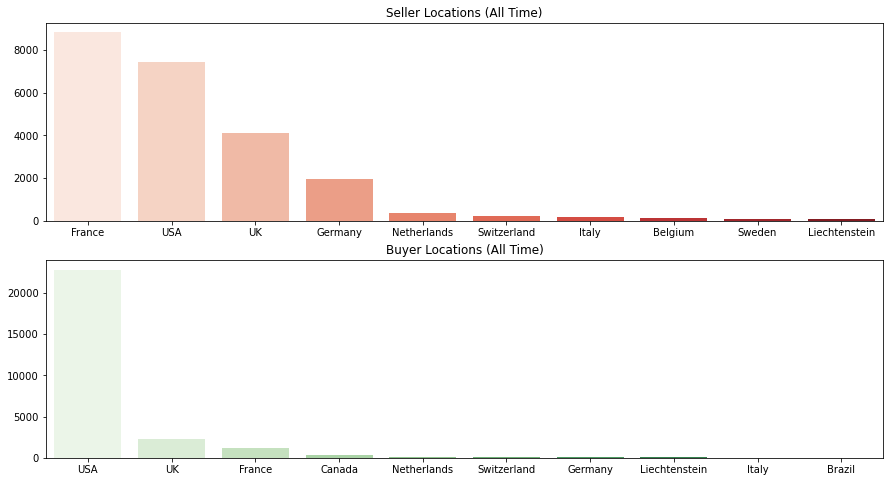

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(15,8))

# Chart seller locations
sns.barplot(
    x=seller_country_count.head(10).index, 
    y=seller_country_count.head(10).values, 
    ax=axs[0], 
    palette='Reds'
)

# Chart buyer locations
sns.barplot(
    x=buyer_country_count.head(10).index, 
    y=buyer_country_count.head(10).values, 
    ax=axs[1], 
    palette='Greens'
)

axs[0].set_title('Seller Locations (All Time)')
axs[1].set_title('Buyer Locations (All Time)');

It couldn't be any clearer that the vast majority of the dealer's inventory originated in France and the US, with still-substantial numbers of purchases made from the UK and Germany; whereas it did almost all of its selling in the US--unsurprising for a New York City-based dealer, but there you go.

These charts reflect the dealer's overall transactions. But what if we wanted to get a sense for whether they changed over time? For this we'll need to incorporate <code>purch_date_year</code> (to match with our seller locations) and <code>sale_date_year</code> (to match with buyer locations). Let's see how much representation we have in the dataset for records with both pieces of information.

In [5]:
# Make additional masks for legibility
has_entry_date = (knoedler['entry_date_year'].notna())
has_sale_date = (knoedler['sale_date_year'].notna())

# Print number of records with valid entry date and valid seller location
print("Valid entry date/seller location pair: {0:,} records (of {1:,} with seller location only)"
      .format(
          len(knoedler[has_sell_loc & has_entry_date]),
          len(knoedler[has_sell_loc])
      )
     )

# Print number of records with valid sale date and valid buyer location
print("Valid sale date/buyer location pair: {0:,} records (of {1:,} with buyer location only)"
      .format(
          len(knoedler[has_buy_loc & has_sale_date]),
          len(knoedler[has_buy_loc])
      )
     )

Valid entry date/seller location pair: 23,097 records (of 23,476 with seller location only)
Valid sale date/buyer location pair: 26,836 records (of 27,198 with buyer location only)


This is what we like to see: Almost every record with a valid seller location has a matching entry date in the stock books, and almost every record with a valid buyer location has a matching sale date. In that case, let's re-slice the original dataset so we can have location information and date information.

In [6]:
# Create new DataFrame specific to purchase-type transactions
entry = knoedler[has_sell_loc & has_entry_date][[
    'pi_record_no',
    'entry_date_year',
    'sell_auth_loc_1_single',
]]

entry['location'] = entry['sell_auth_loc_1_single'].str.extract(r'(?<=, )([^,]+?)$', expand=False)
entry['transaction'] = 'purchase'
entry.drop(columns=['sell_auth_loc_1_single'], inplace=True)
entry.rename(columns={'entry_date_year':'year'}, inplace=True)

entry

,pi_record_no,year,location,transaction
0,K-1,1906.0,France,purchase
30,K-31,1878.0,France,purchase
33,K-34,1876.0,USA,purchase
34,K-35,1876.0,USA,purchase
35,K-36,1876.0,USA,purchase
...,...,...,...,...
40245,K-40442,1875.0,USA,purchase
40246,K-23858,1875.0,USA,purchase
40247,K-23859,1875.0,USA,purchase
40248,K-40336,1902.0,USA,purchase


Now I'll do the same for sale-type transactions, and then I'll concatenate the two together. My goal is to go for long-form data, since I intend to take advantage of Seaborn's plotting methods.

In [7]:
# Create DataFrame specific to sale-type transactions
sale = knoedler[has_sell_loc & has_sale_date][[
    'pi_record_no',
    'sale_date_year',
    'buy_auth_loc_1_single',
]]

sale['location'] = sale['buy_auth_loc_1_single'].str.extract(r'(?<=, )([^,]+?)$', expand=False)
sale['transaction'] = 'sale'
sale.drop(columns=['buy_auth_loc_1_single'], inplace=True)
sale.rename(columns={'sale_date_year':'year'}, inplace=True)

# Concatenate sale and entry DataFrames
locations = pd.concat([sale, entry], ignore_index=True)
locations

,pi_record_no,year,location,transaction
0,K-1,1907.0,USA,sale
1,K-31,1878.0,USA,sale
2,K-34,1877.0,USA,sale
3,K-35,1878.0,USA,sale
4,K-36,1878.0,USA,sale
...,...,...,...,...
39438,K-40442,1875.0,USA,purchase
39439,K-23858,1875.0,USA,purchase
39440,K-23859,1875.0,USA,purchase
39441,K-40336,1902.0,USA,purchase


What I want to do next is count up the number of transactions, by decade rather than year, for each country and for each transaction type. So first I'll start by manipulating the concatenated <code>locations</code> DataFrame so that it's useful for this purpose.

In [8]:
decade = 10 * (locations['year'].astype(int) // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'

locations = (
    locations
    .groupby(['transaction', 'location', decade])[['pi_record_no']]
    .count()
    .unstack()
    .fillna(0)
    .stack()
    .rename(columns={'pi_record_no':'count'})
)

locations.unstack()

count                                          \
decade                      1870s   1880s   1890s   1900s   1910s   1920s   
transaction location                                                        
purchase    Argentina         0.0     0.0     0.0     0.0     0.0     0.0   
            Bahamas           0.0     0.0     0.0     0.0     0.0     0.0   
            Belgium         120.0     7.0     0.0     0.0     2.0     9.0   
            Brazil            0.0     0.0     0.0     0.0     0.0     0.0   
            Canada            1.0     1.0     1.0     3.0     1.0    12.0   
            France         2528.0  1571.0  1378.0   899.0   258.0   436.0   
            Germany        1196.0   531.0    71.0     6.0     5.0    83.0   
            Hungary           0.0     0.0     0.0     0.0     1.0     1.0   
            Ireland           0.0     0.0     0.0     0.0     0.0     3.0   
            Italy             4.0     2.0     0.0     2.0     2.0    13.0   
            Japan             0.0     0.0     0.0     0.0     0.0     0.0   
            Liechtenstein     0.0     0.0     0.0     0.0     0.0     0.0   
            México            0.0     0.0     0.0     0.0     0.0     0.0   
            Netherlands       0.0    20.0    84.0   180.0    28.0    35.0   
            Norway            0.0     0.0     0.0     0.0     1.0     0.0   
            Spain             0.0     0.0     0.0     1.0     0.0     0.0   
            Sweden            0.0     3.0     0.0     0.0     1.0     1.0   
            Switzerland       0.0     0.0     0.0     0.0     0.0    12.0   
            UK              201.0   156.0   197.0   397.0   655.0  1156.0   
            USA             634.0   428.0   467.0   853.0   767.0   696.0   
sale        Argentina         0.0     0.0     0.0     0.0     0.0     0.0   
            Australia         0.0     0.0     0.0     0.0     0.0     2.0   
            Bahamas           0.0     0.0     0.0     0.0     0.0     0.0   
            Belgium           0.0     0.0     0.0     0.0     0.0     0.0   
            Brazil            0.0     0.0     0.0     0.0     0.0     0.0   
            Canada            3.0    11.0     8.0    23.0     4.0    32.0   
            Cuba              0.0     0.0     0.0     0.0     0.0     0.0   
            Denmark           0.0     0.0     0.0     0.0     0.0     0.0   
            El Salvador       0.0     0.0     0.0     0.0     0.0     0.0   
            Finland           0.0     0.0     0.0     0.0     0.0     0.0   
            France          114.0    11.0    67.0   142.0    96.0    64.0   
            Germany           2.0     1.0     5.0     0.0     1.0     9.0   
            Holland           0.0     0.0     0.0     0.0     0.0     3.0   
            Hungary           0.0     0.0     0.0     0.0     2.0     0.0   
            Ireland           0.0     0.0     0.0     0.0     1.0     0.0   
            Italy             0.0     0.0     0.0     0.0     1.0     1.0   
            Japan             0.0     0.0     0.0     0.0     0.0     0.0   
            Liechtenstein     0.0     0.0     0.0     0.0     0.0     0.0   
            Monaco            0.0     0.0     0.0     0.0     0.0     0.0   
            México            0.0     0.0     0.0     0.0     0.0     0.0   
            Netherlands       0.0     0.0     3.0    27.0    19.0    30.0   
            Norway            0.0     0.0     0.0     0.0     1.0     0.0   
            Panama            0.0     0.0     0.0     0.0     0.0     0.0   
            Spain             0.0     0.0     0.0     0.0     0.0    10.0   
            Sweden            0.0     0.0     0.0     0.0     0.0     0.0   
            Switzerland       0.0     0.0     0.0     0.0     0.0     3.0   
            UK               10.0     2.0    29.0    76.0   238.0   299.0   
            USA            2549.0  1910.0  1540.0  1747.0  1003.0  1075.0   
            Venezuela         0.0     0.0     0.0     0.0     0.0     0.0   

                       

Seeing the dataset in this form practically begs for a heatmap.

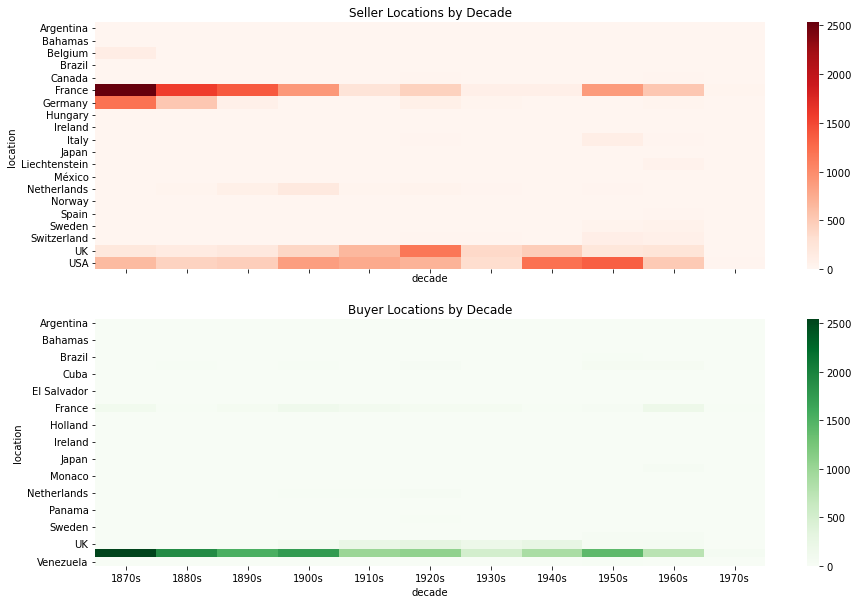

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.heatmap(locations.loc['purchase']['count'].unstack(), ax=axs[0], cmap='Reds')
sns.heatmap(locations.loc['sale']['count'].unstack(), ax=axs[1], cmap='Greens')

axs[0].set_title('Seller Locations by Decade')
axs[1].set_title('Buyer Locations by Decade');

I'm not sure why the USA label is missing from the lower chart, but no matter—the results are stark indeed! Let's do the same thing again, but let's get rid of the outliers—countries that account for only a handful of transactions over the dealer's history.

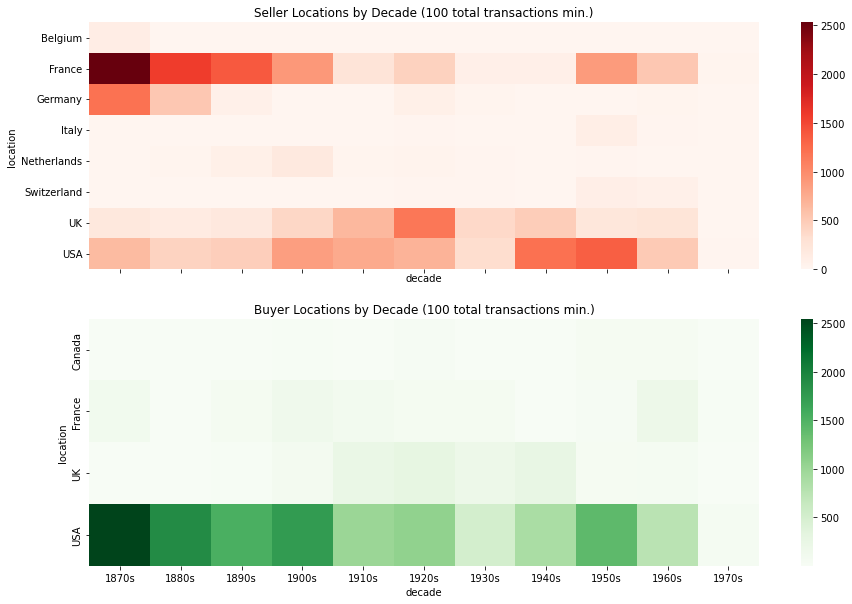

In [10]:
purch = locations.loc['purchase']['count'].unstack()
sale = locations.loc['sale']['count'].unstack()

fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.heatmap(purch[purch.sum(axis=1)>100], ax=axs[0], cmap='Reds')
sns.heatmap(sale[sale.sum(axis=1)>100], ax=axs[1], cmap='Greens')

axs[0].set_title('Seller Locations by Decade (100 total transactions min.)')
axs[1].set_title('Buyer Locations by Decade (100 total transactions min.)');

This is very useful: we immediately get a sense of where Knoedler acquired its inventory based on seller locations (early on France and to a lesser extent Germany, and over the course of the 20th century increasingly the UK and the US); and likewise we get a sense of where Knoedler did most of its selling based, conversely, on buyer locations (the US pretty much).

We could look at the same data in a line chart, which might clarify the changes over time to an even greater extent.

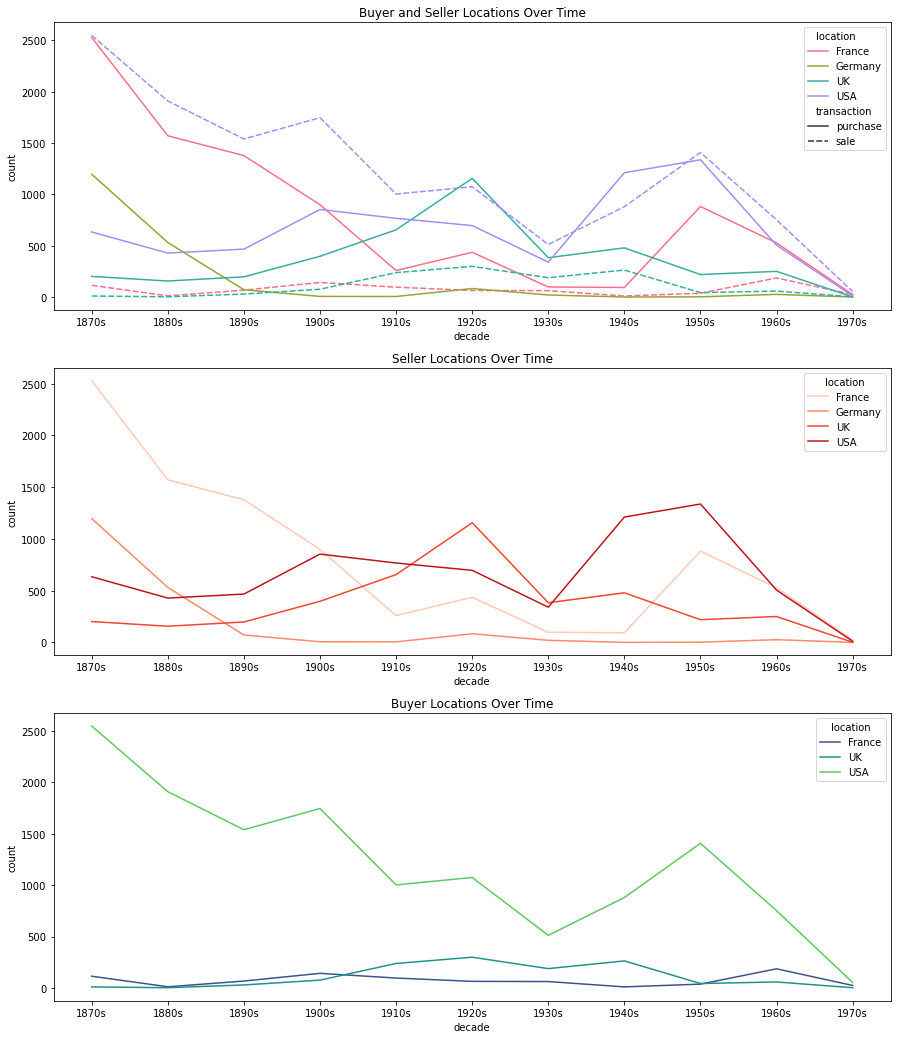

In [11]:
# Limit dataset to countries meeting a certain threshhold of transactions
linechart = locations.unstack()
linechart = linechart[linechart.sum(axis=1)>500]

# Re-convert dataset to long-form to take advantage of Seaborn
linechart = linechart.stack().reset_index()

fig, axs = plt.subplots(3, 1, figsize=(15,18))

# Chart bother buyer and seller locations
sns.lineplot(
    data=linechart, 
    x='decade', 
    y='count', 
    hue='location', 
    style='transaction', 
    palette='husl', 
    ax=axs[0]
)

# Chart seller locations only
sns.lineplot(
    data=linechart[linechart['transaction'] == 'purchase'], 
    x='decade', 
    y='count', 
    hue='location', 
    palette='Reds', 
    ax=axs[1]
)

#Chart buyer location only
sns.lineplot(
    data=linechart[linechart['transaction'] == 'sale'], 
    x='decade', 
    y='count', 
    hue='location', 
    palette='viridis', 
    ax=axs[2])

axs[0].set_title('Buyer and Seller Locations Over Time')
axs[1].set_title('Seller Locations Over Time')
axs[2].set_title('Buyer Locations Over Time');


I was tempted to generate one chart with both buyer and seller locations (top), but it's a little messy and illegible, so I opted for buyer- and seller-specific charts as well, which I think tell the story more clearly.

In terms of seller locations (i.e., where Knoedler acquired its inventory), we can clearly see that France was, early on, the main origin point until the turn of the century. After that there are some notable moments: a spike in UK acquisitions in the 1920s, the expected lull in acquisitions, period, in the 1930s, and then in the 1940s and '50s increased buying stateside.

The story is clearer when it comes to the dealer's sales: buyers were almost exclusively located in the US, as expected.

### Buyer and Seller Locations as Percentage

Because the above charts indicate a decreasing transaction volume over time, it's slightly difficult to get a clear sense of how these transactions relate proportionally, that is, as a ratio of all transactions in a given ten-year span. So I'm curious to think about buyer and seller locations as a proportion of all transactions, which would provide a better sense for how the composition of the dealer's clientele, both on the buyer side and seller side, change over time.

In [12]:
# Re-arrange locations DataFrame so that countries are columns
locations_pct = locations.unstack(level=1).fillna(0)

# Sum each row since we need total transactions for each decade/transaction type
tot = locations_pct.sum(axis=1)

# Divide transaction count by total to get percentage
locations_pct = locations_pct.divide(tot, axis=0)['count']

# For clarity, create buyer location and seller location DataFrames with locations as index
sellers = locations_pct.loc['purchase'].T
buyers = locations_pct.loc['sale'].T

# Limit each DataFrame to countries that, on average, account for > 2% of each decade's
# sales and then flatten DataFrames to long-form
sellers = (
    sellers[sellers.mean(axis=1)>0.02]
    .stack()
    .reset_index()
    .rename(columns={0:'percentage'})
)
buyers = (
    buyers[buyers.mean(axis=1)>0.02]
    .stack()
    .reset_index()
    .rename(columns={0:'percentage'})
)

# Display one DataFrame to see where we've ended up
sellers

,location,decade,percentage
0,France,1870s,0.539710
1,France,1880s,0.577786
2,France,1890s,0.626934
3,France,1900s,0.384024
4,France,1910s,0.149913
5,France,1920s,0.177452
6,France,1930s,0.111745
7,France,1940s,0.051984
8,France,1950s,0.322368
9,France,1960s,0.343099


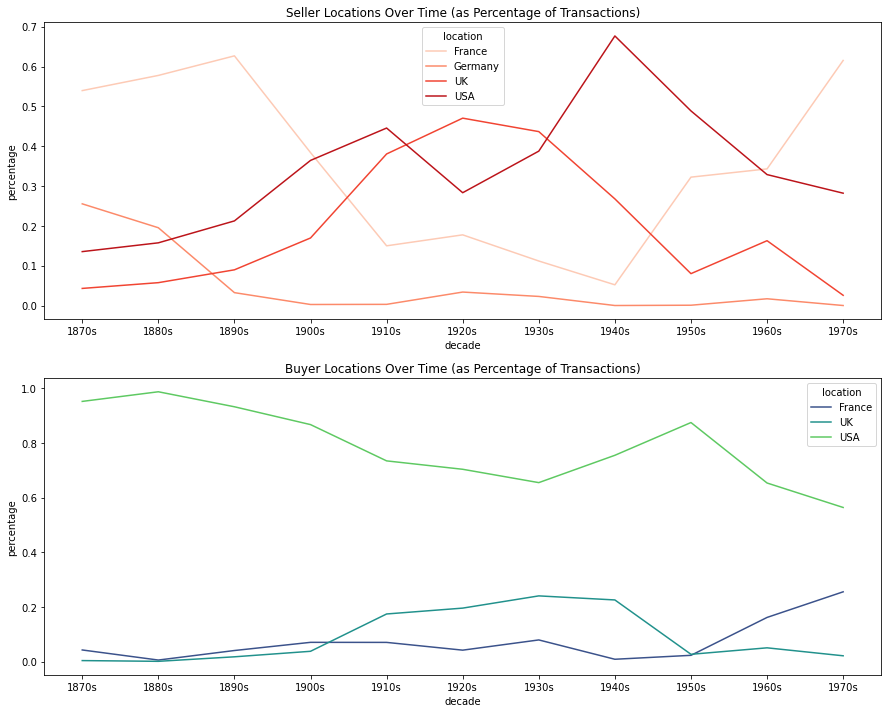

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,12))

# Chart seller locations only
sns.lineplot(
    data=sellers, 
    x='decade', 
    y='percentage', 
    hue='location', 
    palette='Reds', 
    ax=axs[0]
)

#Chart buyer location only
sns.lineplot(
    data=buyers, 
    x='decade', 
    y='percentage', 
    hue='location', 
    palette='viridis', 
    ax=axs[1])

axs[0].set_title('Seller Locations Over Time (as Percentage of Transactions)')
axs[1].set_title('Buyer Locations Over Time (as Percentage of Transactions)');


I think these charts are useful, since they help us obtain a bit more nuance about how the composition of Knoedler's clientele changed over time.

When Knoedler was adding to its inventory, we can see that early on France accounted for over half of its incoming transactions. By the turn of the century, Knoedler was increasingly relying on the UK and the US when sourcing artworks. And in its final decade, France began once again to account for the majority of its acquisitions.

When Knoedler was selling, on the other hand, we can see that the vast majority of works were placed in the US. Interestingly, however, the largely decreased around the turn of the century as Knoedler increasingly placed art in the UK and, in its final decades, in France.

### Origin-Destination Pairs

The last project I want to attempt in this notebook is to get a sense for specific vectors of travel—not only where Knoedler's inventory originated and ended up in aggregate, but specifically where objects from, say, the UK tended to end up.

In [14]:
# Create Series extracting seller countries from all records with valid seller and buyer locations
seller_country = pd.Series(
    knoedler[has_sell_loc & has_buy_loc]['sell_auth_loc_1_single']
    .str
    .extract(r'(?<=, )([^,]+?)$', expand=False)
    , name='Seller Loc'
)

# Create Series extracting buyer countries from all records with valid seller and buyer locations
buyer_country = pd.Series(
    knoedler[has_sell_loc & has_buy_loc]['buy_auth_loc_1_single']
    .str
    .extract(r'(?<=, )([^,]+?)$', expand=False)
    , name='Buyer Loc'
)

# Create DataFrame from above series, which will have matched seller and buyer locations
locpairs = pd.DataFrame(data=[seller_country, buyer_country]).T
locpairs

,Seller Loc,Buyer Loc
0,France,USA
30,France,USA
33,USA,USA
34,USA,USA
35,USA,USA
...,...,...
40245,USA,USA
40246,USA,USA
40247,USA,USA
40248,USA,USA


Next, what I want to do is count up each unique seller location/buyer location pair. I envision a new DataFrame with buyer locations on one axis and seller locations on the other, with each cell offering a count of the number of transactions between that buyer/seller pair. So, first, I'll create an empty DataFrame to hold the counts.

In [15]:
# Use unique values from the seller_country DataFrame for index and unique
# values from the buyer_country DataFrame for columns
locpairs_count = (
    pd.DataFrame(
        index=pd.Index(np.sort(seller_country.unique()), name='Seller'), 
        columns=pd.Index(np.sort(buyer_country.unique()), name='Buyer')
    )
    .fillna(0)
)

locpairs_count

Buyer,Argentina,Australia,Bahamas,Belgium,Brazil,Canada,Cuba,Denmark,El Salvador,Finland,...,México,Netherlands,Norway,Panama,Spain,Sweden,Switzerland,UK,USA,Venezuela
Seller,,,,,,,,,,,,,,,,,,,,,
Bahamas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Belgium,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brazil,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Canada,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
France,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Germany,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ireland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Italy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Japan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, I'll loop through the <code>locpairs</code> DataFrame, each time incrementing cell with the matching buyer/seller pair in the <code>locpairs_count</code> DataFrame.

In [16]:
for i in range(len(locpairs)):
    seller = locpairs.iloc[i, 0]
    buyer = locpairs.iloc[i, 1]
    locpairs_count.loc[seller, buyer] += 1

locpairs_count

Buyer,Argentina,Australia,Bahamas,Belgium,Brazil,Canada,Cuba,Denmark,El Salvador,Finland,...,México,Netherlands,Norway,Panama,Spain,Sweden,Switzerland,UK,USA,Venezuela
Seller,,,,,,,,,,,,,,,,,,,,,
Bahamas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Belgium,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2,72,0
Brazil,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
Canada,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,28,0
France,0,0,0,2,3,57,0,1,0,4,...,1,8,3,1,5,3,21,75,5536,4
Germany,0,0,0,0,0,5,0,0,0,0,...,0,7,0,0,0,0,4,24,1153,0
Ireland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Italy,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,2,0,106,0
Japan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, let's look at the above rendered as a heatmap.

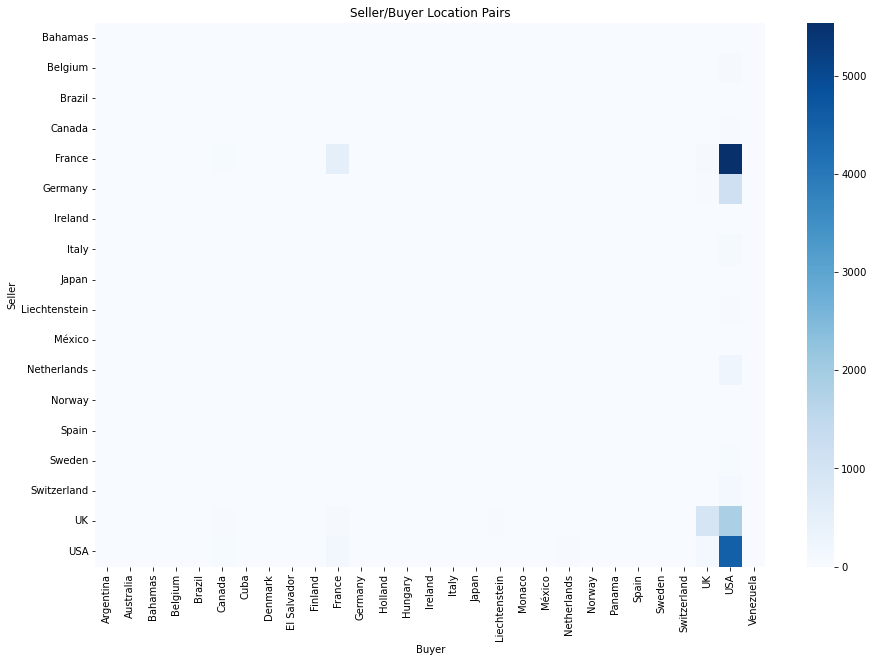

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(locpairs_count, cmap="Blues")
ax.set_title('Seller/Buyer Location Pairs');

The data is so lopsided that really all we see is that the vast, vast majority of Knoedler's buyers, over the course of its entire history, were US-based, and that the artworks that ended up in the US had origins mainly in France, followed by the US, the UK, Germany, and the Netherlands.

To get a little more resolution, let's exclude buyer/seller pairs that account for very little of the dealer's overall activity.

In [18]:
# Unstack to make masking simpler
locpairs_count = locpairs_count.unstack()

# Reconstitute filtered dataset
locpairs_count = (
    locpairs_count[locpairs_count>200]
    .reset_index()
    .set_index(['Seller', 'Buyer'])
    .unstack()
    .fillna(0)
    .rename(columns={0:'count'})['count']
)

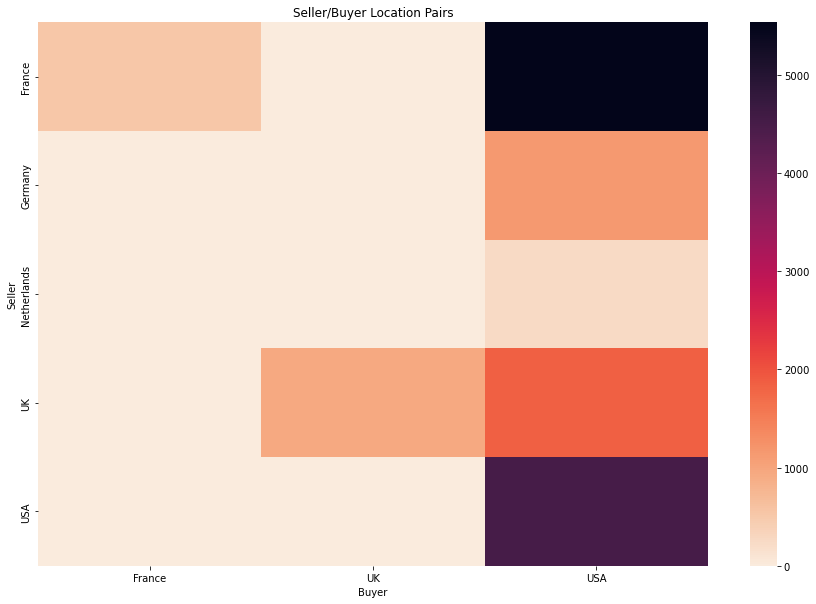

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(locpairs_count, cmap="rocket_r", vmin=0)
ax.set_title('Seller/Buyer Location Pairs');

Now we can see the results a little more clearly. When artworks ended up in France, they seem to have originated in France; same goes for the UK. And as for artworks placed in the US, we clearly see that these originated mostly from France, followed by the US, the UK, Germany, and the Netherlands.